In [ ]:
#| hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
#| default_exp inspect.searchcv_estimator

# SearchCV Estimator

> Inspector functionality for estimators that inherit from `BaseSearchCV`

In [ ]:
#| export
from typing import Optional, Sequence, Union

import matplotlib.pyplot as plt
import pandas as pd
from model_inspector.delegate import delegates
from model_inspector.inspect.any_model import _Inspector
from sklearn.model_selection._search import BaseSearchCV

In [ ]:
#| export
class _SearchCVInspector(_Inspector):
    """Inspector for `BaseSearchCV` models with one hyperparameter"""

    def plot_scores_vs_hparam(
        self,
        hparam: Optional[str] = None,
        score_cols: Optional[Union[str, Sequence[str]]] = None,
        ax=None,
    ):
        """Plot model scores against values of one hyperparameter

        Parameters:
        - `hparam`: Name of the hyperparameter to plot against. Must be
        provided if there are multiple hyperparameters. Any other
        hyperparameters will be fixed at the value they have in
        `self.model.best_params_`.
        - `score_cols`: Name of score columns to plot. By default will
        be the mean test and (if present) train score for the primary
        scoring metric.
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _get_hparam():
            hparams = list(self.model.param_grid.keys())
            if len(hparams) == 1:
                return hparams[0]
            else:
                raise ValueError(
                    "Must provide `hparam` if there are multiple possibilities"
                )

        def _filter_to_best_values_of_other_hparams(results, hparam):
            return results.query(_get_query_string(hparam))

        def _get_query_string(hparam):
            return " & ".join(
                f"param_{param} == {repr(val)}"
                for param, val in self.model.best_params_.items()
                if param != hparam
            )

        def _get_default_score_cols(results):
            score_cols = []
            if self.model.refit is True:
                score_cols.append("mean_test_score")
            else:
                score_cols.append(f"mean_test_{self.model.refit}")
            train_cols = [
                col.replace("test", "train")
                for col in score_cols
                if col.replace("test", "train") in results
            ]
            return score_cols + train_cols

        def _plot_scores(results, hparam, score_cols, ax):
            if isinstance(self.model.best_params_[hparam], str):
                results.plot.bar(x=f"param_{hparam}", y=score_cols, ax=ax)

            else:
                for col in score_cols:
                    results.plot(x=f"param_{hparam}", y=col, ax=ax)
                ax.axvline(
                    self.model.best_params_[hparam],
                    c="k",
                    label=f"{hparam} = {self.model.best_params_[hparam]}",
                )

        if hparam is None:
            hparam = _get_hparam()

        results = pd.DataFrame(self.model.cv_results_)
        if len(self.model.param_grid) > 1:
            results = _filter_to_best_values_of_other_hparams(results, hparam)

        if score_cols is None:
            score_cols = _get_default_score_cols(results)

        if ax is None:
            _, ax = plt.subplots()

        _plot_scores(results, hparam, score_cols, ax)
        ax.set_title(_get_query_string(hparam).replace("==", "="))
        ax.legend()
        return ax

    @delegates(pd.DataFrame().style.background_gradient)
    def show_score_vs_hparam_pair(self, hparams=None, score_col=None, **kwargs):
        """Show model scores against a pair of hyperparameters

        Background gradient uses `axis=None` by default, to facilitate
        identifying the best score across all combinations of
        hyperparameter values.

        Parameters:
        - `hparams`: Name of the hyperparameters to plot against.
        The first two hyperparameters in `self.model.param_grid` will be
        used by default. Any other hyperparameters will be fixed at the
        value they have in `self.model.best_params_`.
        - `score_col`: Name of score column to plot. By default will
        be the mean test score for the primary scoring metric.
        """
        score_col = (
            score_col
            if score_col is not None
            else "mean_test_score"
            if self.model.refit is True
            else f"mean_test_{self.model.refit}"
        )

        all_hparams = list(self.model.best_params_.keys())
        assert len(all_hparams) > 1, "Method requires at least two hyperparameters"
        if hparams is None:
            if len(all_hparams) == 2:
                hparams = all_hparams
            else:
                raise ValueError(
                    """
                        `hparams` must be specified unless there are
                        exactly two hyperparameters
                    """
                )

        results = pd.DataFrame(self.model.cv_results_)
        return (
            results.pivot_table(
                index=f"param_{hparams[0]}", columns=f"param_{hparams[1]}"
            )
            .loc[:, score_col]
            .style.background_gradient(**{**{"axis": None}, **kwargs})
        )

In [ ]:
#| export
_all_ = ["_SearchCVInspector"]

In [ ]:
import sklearn.datasets
from model_inspector.get_inspector import get_inspector
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

grid = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid={
        "min_samples_leaf": (1, 2, 5, 10, 20, 50),
        "max_features": (0.3, 0.5, 1.0),
        "splitter": ("best", "random"),
    },
    n_jobs=-1,
    return_train_score=True,
    cv=KFold(5, shuffle=True),
)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_features': (0.3, 0.5, 1.0),
                         'min_samples_leaf': (1, 2, 5, 10, 20, 50),
                         'splitter': ('best', 'random')},
             return_train_score=True)

/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: Fut

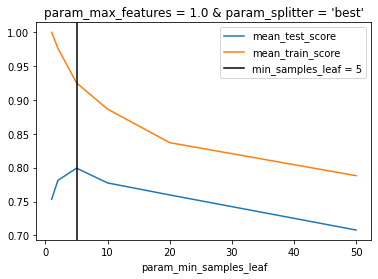

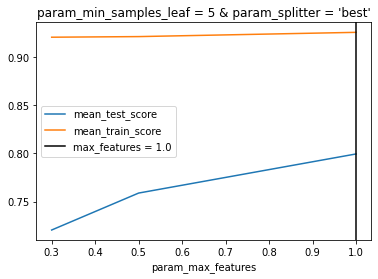

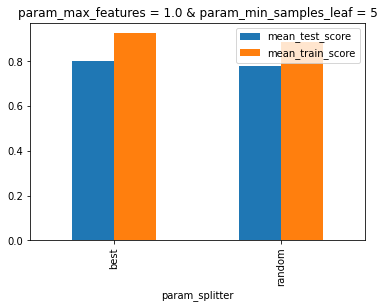

In [ ]:
inspector = get_inspector(grid, X, y)
ax = inspector.plot_scores_vs_hparam("min_samples_leaf")
ax = inspector.plot_scores_vs_hparam("max_features")
ax = inspector.plot_scores_vs_hparam("splitter")

In [ ]:
inspector.show_score_vs_hparam_pair(["min_samples_leaf", "max_features"])

param_max_features,0.300000,0.500000,1.000000
param_min_samples_leaf,,,
1,0.675209,0.657903,0.741727
2,0.717117,0.761373,0.757923
5,0.749972,0.746455,0.788854
10,0.764915,0.776760,0.776176
20,0.748931,0.720813,0.773316
50,0.605996,0.679718,0.681910
